In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    log_loss,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

## Goal: Can we predict whether a player is an All-Star?
## Approach: Logistic Model

In [32]:
players = pd.read_csv('DATA/nba_data_with_salaries.csv')
players.head()

,PLAYER_ID,PLAYER_NAME,NICKNAME_base,TEAM_ID_base,TEAM_ABBREVIATION_base,AGE_base,GP_base,W_base,L_base,W_PCT_base,...,PACE_RANK,sp_work_PACE_RANK,PIE_RANK,FGM_RANK_adv,FGA_RANK_adv,FGM_PG_RANK,FGA_PG_RANK,FG_PCT_RANK_adv,TEAM_COUNT_adv,SALARY
0,203932.0,Aaron Gordon,Aaron,1.610613e+09,DEN,29.0,51.0,33.0,18.0,0.647,...,240.0,240.0,176.0,150.0,182.0,113.0,139.0,79.0,1.0,22841455
1,1628988.0,Aaron Holiday,Aaron,1.610613e+09,HOU,28.0,62.0,39.0,23.0,0.629,...,146.0,146.0,333.0,304.0,297.0,381.0,374.0,325.0,1.0,4668000
2,1630174.0,Aaron Nesmith,Aaron,1.610613e+09,IND,25.0,45.0,29.0,16.0,0.644,...,241.0,241.0,292.0,223.0,238.0,153.0,173.0,116.0,1.0,11000000
3,1630598.0,Aaron Wiggins,Aaron,1.610613e+09,OKC,26.0,76.0,62.0,14.0,0.816,...,221.0,221.0,170.0,95.0,97.0,137.0,142.0,156.0,1.0,10514017
4,1641737.0,Adem Bona,Adem,1.610613e+09,PHI,22.0,58.0,12.0,46.0,0.207,...,343.0,343.0,245.0,280.0,338.0,337.0,424.0,7.0,1.0,1157153


In [33]:
# Initial Exploration of data to look at columns and summary statistics
#players.describe()
players.columns.tolist()


['PLAYER_ID',
 'PLAYER_NAME',
 'NICKNAME_base',
 'TEAM_ID_base',
 'TEAM_ABBREVIATION_base',
 'AGE_base',
 'GP_base',
 'W_base',
 'L_base',
 'W_PCT_base',
 'MIN_base',
 'FGM_base',
 'FGA_base',
 'FG_PCT_base',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'TOV',
 'STL',
 'BLK',
 'BLKA',
 'PF',
 'PFD',
 'PTS',
 'PLUS_MINUS',
 'NBA_FANTASY_PTS',
 'DD2',
 'TD3',
 'WNBA_FANTASY_PTS',
 'GP_RANK_base',
 'W_RANK_base',
 'L_RANK_base',
 'W_PCT_RANK_base',
 'MIN_RANK_base',
 'FGM_RANK_base',
 'FGA_RANK_base',
 'FG_PCT_RANK_base',
 'FG3M_RANK',
 'FG3A_RANK',
 'FG3_PCT_RANK',
 'FTM_RANK',
 'FTA_RANK',
 'FT_PCT_RANK',
 'OREB_RANK',
 'DREB_RANK',
 'REB_RANK',
 'AST_RANK',
 'TOV_RANK',
 'STL_RANK',
 'BLK_RANK',
 'BLKA_RANK',
 'PF_RANK',
 'PFD_RANK',
 'PTS_RANK',
 'PLUS_MINUS_RANK',
 'NBA_FANTASY_PTS_RANK',
 'DD2_RANK',
 'TD3_RANK',
 'WNBA_FANTASY_PTS_RANK',
 'TEAM_COUNT_base',
 'NICKNAME_adv',
 'TEAM_ID_adv',
 'TEAM_ABBREVIATION_adv',
 'AGE_adv',
 'GP_adv

In [34]:
# players['PIE_RANK'].value_counts()
# players["PIE_RANK"].isnull().sum()
players['PIE_RANK'].describe()

count    468.000000
mean     263.130342
std      155.706204
min        2.000000
25%      128.750000
50%      255.500000
75%      399.250000
max      557.000000
Name: PIE_RANK, dtype: float64

In [35]:
players["all_star"] = (players["PIE_RANK"] <= 24).astype(int)
print("Class balance (all_star):")
print(players["all_star"].value_counts())
print(players["all_star"].value_counts(normalize=True))

Class balance (all_star):
all_star
0    448
1     20
Name: count, dtype: int64
all_star
0    0.957265
1    0.042735
Name: proportion, dtype: float64


In [36]:
# Identify numeric columns
num_cols = players.select_dtypes("number").columns.tolist()

# Identify ID columns because they are descriptions and need to be excluded
id_cols = [id_col for id_col in num_cols if "ID" in id_col.upper()]
id_cols


['PLAYER_ID', 'TEAM_ID_base', 'TEAM_ID_adv']

In [37]:
players[id_cols].head(20)


,PLAYER_ID,TEAM_ID_base,TEAM_ID_adv
0,203932.0,1.610613e+09,1.610613e+09
1,1628988.0,1.610613e+09,1.610613e+09
2,1630174.0,1.610613e+09,1.610613e+09
3,1630598.0,1.610613e+09,1.610613e+09
4,1641737.0,1.610613e+09,1.610613e+09
5,1642349.0,1.610613e+09,1.610613e+09
6,1631260.0,1.610613e+09,1.610613e+09
7,1642358.0,1.610613e+09,1.610613e+09
8,1630639.0,1.610613e+09,1.610613e+09
9,202692.0,1.610613e+09,1.610613e+09


In [38]:
# these colums need to be excluded because aren't player statistics
players[["TEAM_COUNT_base", "TEAM_COUNT_adv"]].head(10)

,TEAM_COUNT_base,TEAM_COUNT_adv
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
5,1.0,1.0
6,1.0,1.0
7,2.0,2.0
8,1.0,1.0
9,1.0,1.0


Accuracy: 0.957
Log loss: 0.103
ROC AUC: 1.0


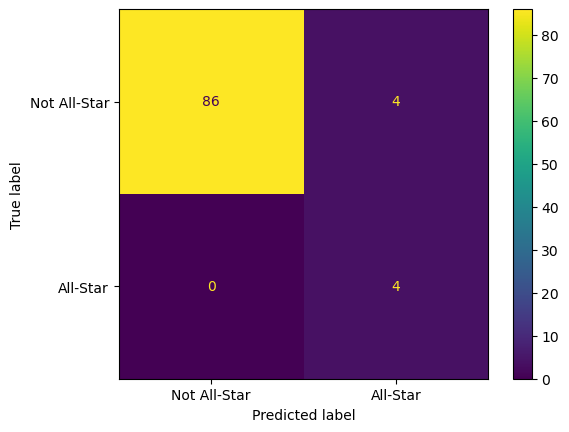

In [ ]:
drop_cols = [
    "all_star",        # target
    "PLAYER_ID",       # an ID
    "TEAM_ID_base",    # an ID
    "TEAM_ID_adv",     # an ID
    "TEAM_COUNT_base", # not a player stat
    "TEAM_COUNT_adv",  # not a player stat
    "PIE",             # underlying metric used for ranking
    "PIE_RANK",        # used to define target
]

# removes the inappropriate columns if they are numeric
X_cols = [c for c in num_cols if c not in drop_cols]

X = players[X_cols]
y = players["all_star"]

# Train–test split, stratify to prevent class inbalance
# Used a typical 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42
)

logit_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()), # logistic needs standardized features
    ("model", LogisticRegression(
        class_weight="balanced",  # handle class imbalance (~4% positives), so that there is more importance to rare positive examples
        solver="liblinear",
        max_iter=1000,
    ))
])

logit_pipe.fit(X_train, y_train) # fit the model are the training data

 
proba_test = logit_pipe.predict_proba(X_test)[:, 1] # Evaluate on the test set
y_pred = (proba_test >= 0.5).astype(int)
acc = round(accuracy_score(y_test, y_pred), 3)
ll = round(log_loss(y_test, proba_test), 3)
auc = round(roc_auc_score(y_test, proba_test), 3)

print("Accuracy:", acc)
print("Log loss:", ll)
print("ROC AUC:", auc)

cm = confusion_matrix(y_test, y_pred)

# Here is the displayed data
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Not All-Star", "All-Star"]
)
disp.plot()





In [40]:
# accuracy = (TP + TN) / (TP + TN + FP + FN)
# precision = TP / (TP + FP)
# recall = TP / (TP + FN)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

accuracy = (TP + TN) / (TP + TN + FP + FN) # Here are the metrics from above
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)


print("Confusion Matrix Values")
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)
print("True Positives:", TP)

print("\nModel Performance Metrics")
print("Accuracy:", round(accuracy, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))
print("F1 Score:", round(f1, 3))


Confusion Matrix Values
True Negatives: 86
False Positives: 4
False Negatives: 0
True Positives: 4

Model Performance Metrics
Accuracy: 0.957
Precision: 0.5
Recall: 1.0
F1 Score: 0.667
